## Credit Card Customer Clustering

### Import Libraries

In [1]:
import pandas as pd      # for data manipulation and analysis
import numpy as np       # for numerical computing
import matplotlib.pyplot as plt     # for data visualization
import matplotlib.dates as mdates   
import seaborn as sns    # for advanced data visualization
import sklearn           # for machine learning algorithms
from sklearn.feature_selection import mutual_info_classif
import statsmodels.api as sm        # for statistical models and tests
import scipy.stats as stats         # for scientific computing and statistics
import random
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from datetime import datetime

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
#mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
#mpl.rc('ytick', labelsize=12)

from termcolor import colored
import pylab
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

C:\Users\peter\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Data information

This case requires to develop a customer segmentation to define marketing strategy. The
sample Dataset summarizes the usage behavior of about 9000 active credit card holders during the 6 months. The file is at a customer level with 18 behavioral variables.

Following is the Data Dictionary for Credit Card dataset :-

- **CUST_ID** : Identification of Credit Card holder (Categorical)
- **BALANCE** : Balance amount left in their account to make purchases (
- **BALANCE_FREQUENCY** : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- **PURCHASES** : Amount of purchases made from account
- **ONEOFF_PURCHASES** : Maximum purchase amount done in one-go
- **INSTALLMENTS_PURCHASES** : Amount of purchase done in installment
- **CASH_ADVANCE** : Cash in advance given by the user
- **PURCHASES_FREQUENCY** : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- **ONEOFFPURCHASESFREQUENCY** : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- **PURCHASESINSTALLMENTSFREQUENCY** : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- **CASHADVANCEFREQUENCY** : How frequently the cash in advance being paid
- **CASHADVANCETRX** : Number of Transactions made with "Cash in Advanced"
- **PURCHASES_TRX** : Numbe of purchase transactions made
- **CREDIT_LIMIT** : Limit of Credit Card for user
- **PAYMENTS** : Amount of Payment done by user
- **MINIMUM_PAYMENTS** : Minimum amount of payments made by user
- **PRCFULLPAYMENT** : Percent of full payment paid by user
- **TENURE** : Tenure of credit card service for user

### Import data

In [7]:
# Set the file path and name
path = './data/CC_GENERAL.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(path)

# Copy of dataset
df_original = df

### Auxiliar Functions

In [22]:
# Function to print main info about the dataset

def ds_info(df):
    print(colored('SIZE' , 'blue', attrs=['bold', 'dark']))
    print(df.size)
    print(colored('\nSHAPE' , 'blue', attrs=['bold', 'dark']))
    print(df.shape)
    print(colored('\nINFO' , 'blue', attrs=['bold', 'dark']))
    print(df.info())
    print(colored('\nNULL VALUES' , 'blue', attrs=['bold', 'dark']))
#    print(df.isnull().sum())
    print(df.isna().mean()*100)
#    print(colored('\nHEAD' , 'blue', attrs=['bold', 'dark']))
#    print(df.head())
#    print(colored('\nTAIL' , 'blue', attrs=['bold', 'dark']))
#    print(df.tail())
#    print(colored('\nDESCRIBE - Numerical' , 'blue', attrs=['bold', 'dark']))
#    print(df.describe())
#    print(colored('\nDESCRIBE - Categorical' , 'blue', attrs=['bold', 'dark']))
#    print(df.describe(include='object'))
    
    print(colored('\nUNIQUE ENTRIES IN EACH NUMERICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with numerical data
    num_cols = [col for col in df.columns if df[col].dtype != "object"]
    num_nunique = list(map(lambda col: df[col].nunique(), num_cols))    
    dn = dict(zip(num_cols, num_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dn.items(), key=lambda x: x[1]))
    
    print(colored('\nUNIQUE ENTRIES IN EACH CATEGORICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with categorical data
    object_cols = [col for col in df.columns if df[col].dtype == "object"]
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    dc = dict(zip(object_cols, object_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dc.items(), key=lambda x: x[1]))


### Data overview

In [23]:
ds_info(df)

SIZE
161100

SHAPE
(8950, 18)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                 

In [10]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [21]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


**Analysis**:
- The dataset consists of 18 columns, including 1 object column (CUST_ID) and 3 integer columns, while the remaining columns are of float type.

- Among the variables, there are two columns with null values. The "MINIMUM_PAYMENTS" column has null values in approximately 3.5% of the data, while the "CREDIT_LIMIT" column has null values in only 0.01% of the data.

- There are several variables in the dataset where the mean is significantly higher than the median. This suggests the presence of skewness in these variables, indicating a potential imbalance or non-normal distribution. Further investigation is necessary to understand the nature and implications of this skewness in the dataset.

### Exploratory Data Analysis

#### Null values

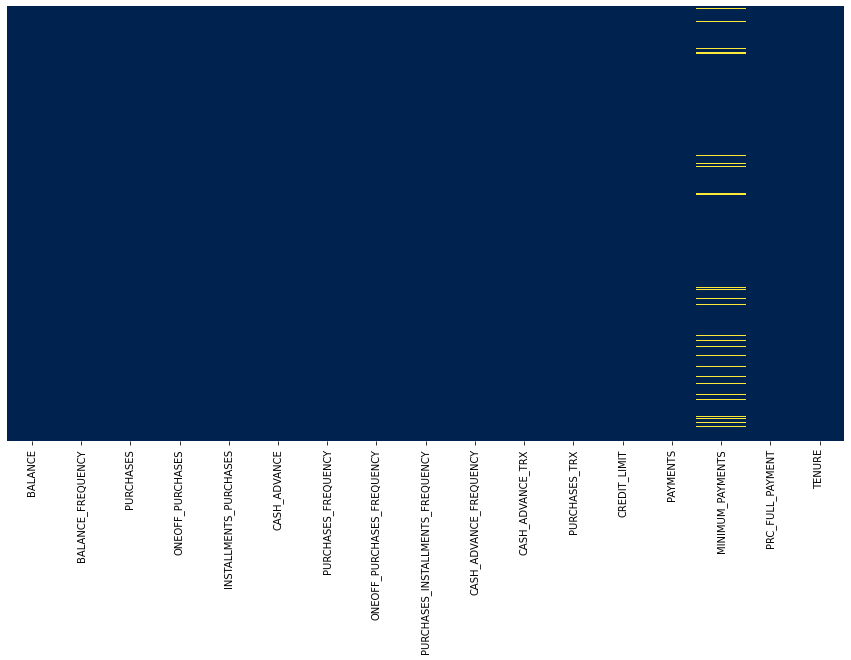

In [34]:
# Select all columns
columns_to_visualize = df.columns[1:20]

# Create a subset DataFrame with selected columns
subset = df[columns_to_visualize]
# Increase the size of the plot
plt.figure(figsize=(15, 8))
# Generate the heatmap
sns.heatmap(subset.isnull(),yticklabels=False,cbar=False,cmap='cividis')
# Display
plt.show()

#### Skewness analysis

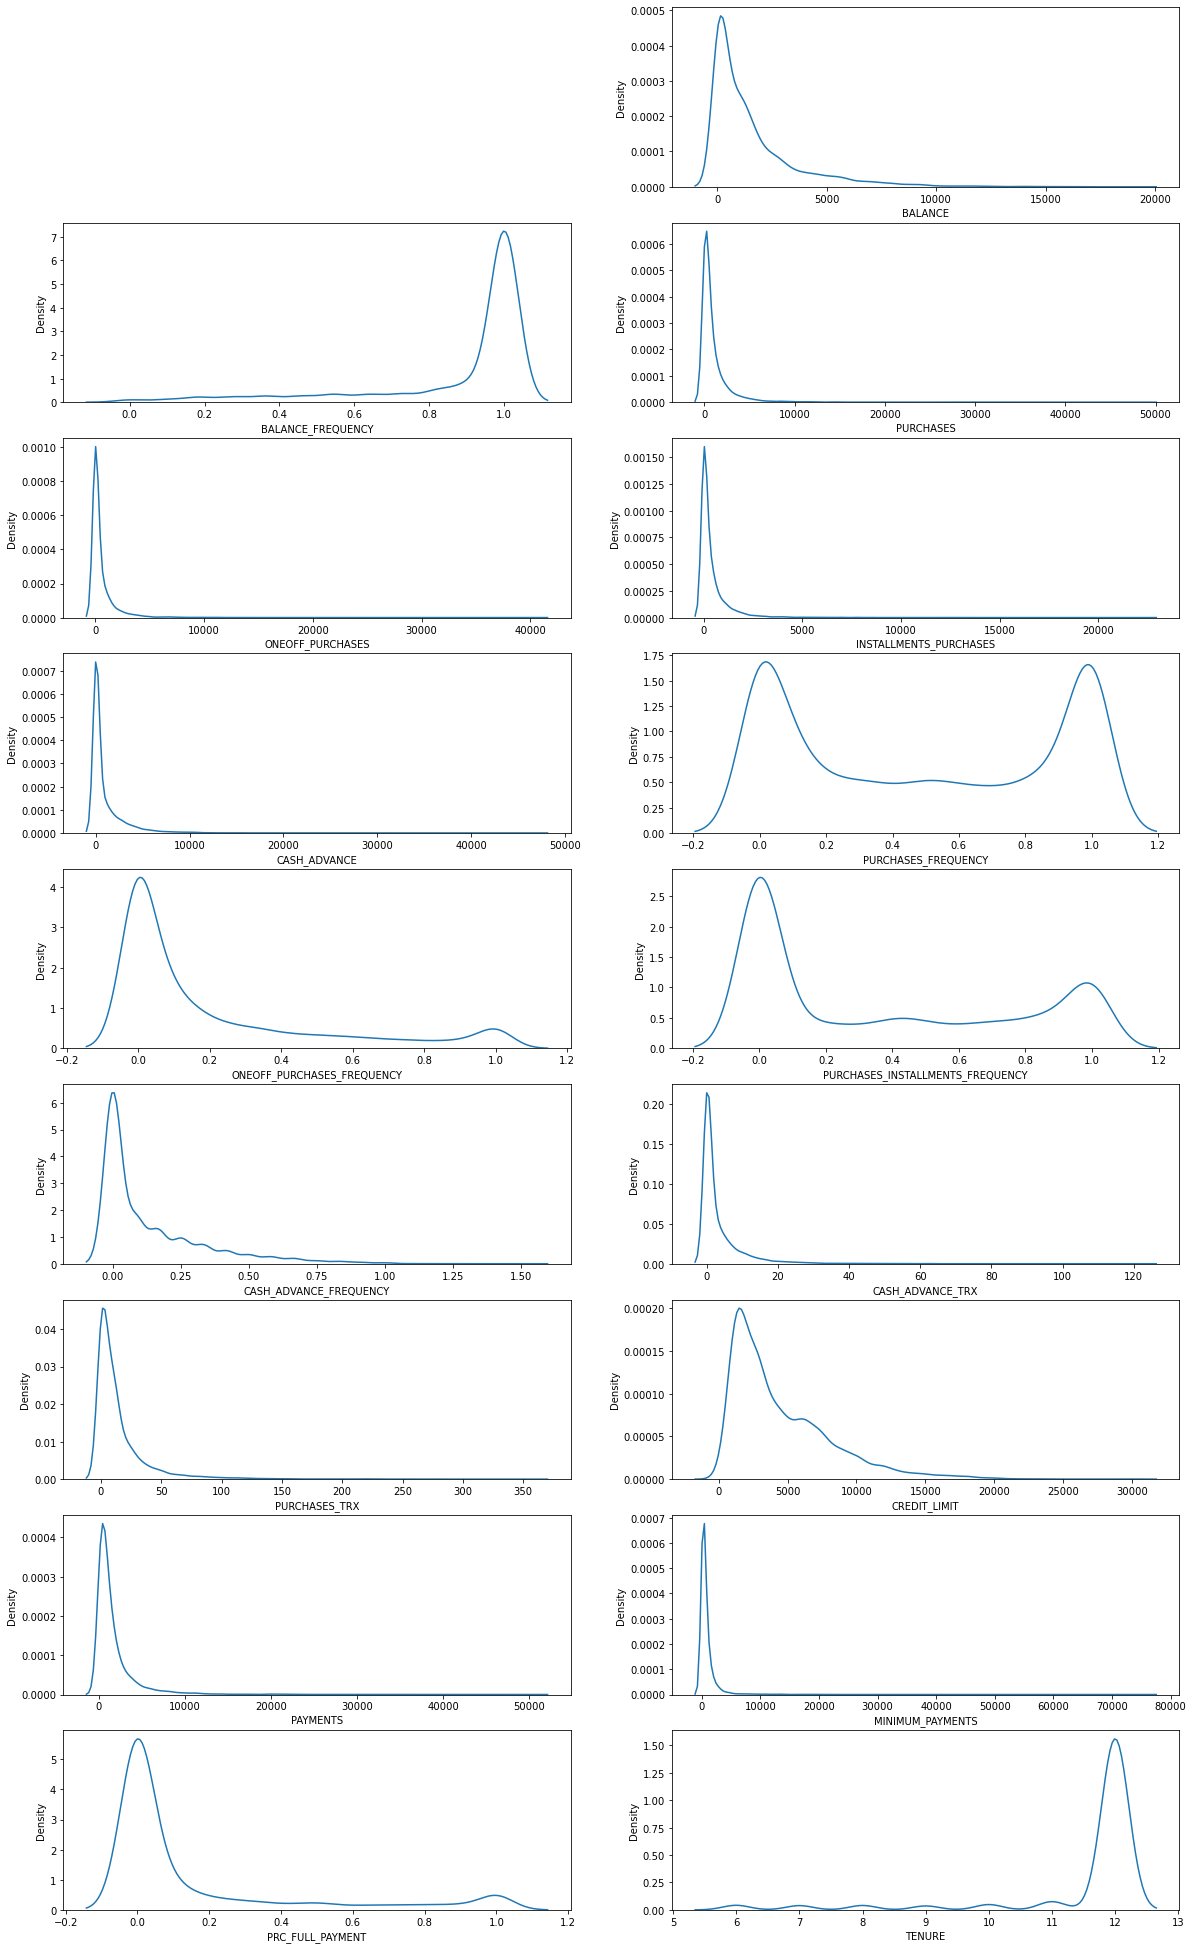

In [35]:
plt.figure(figsize=(20,35))
for i, col in enumerate(df.columns):
    if df[col].dtype != 'object':
        ax = plt.subplot(9, 2, i+1)
        sns.kdeplot(df[col], ax=ax)
        plt.xlabel(col)
        
plt.show()

#### Correlation

<AxesSubplot:title={'center':'Pearson correlation of float features'}>

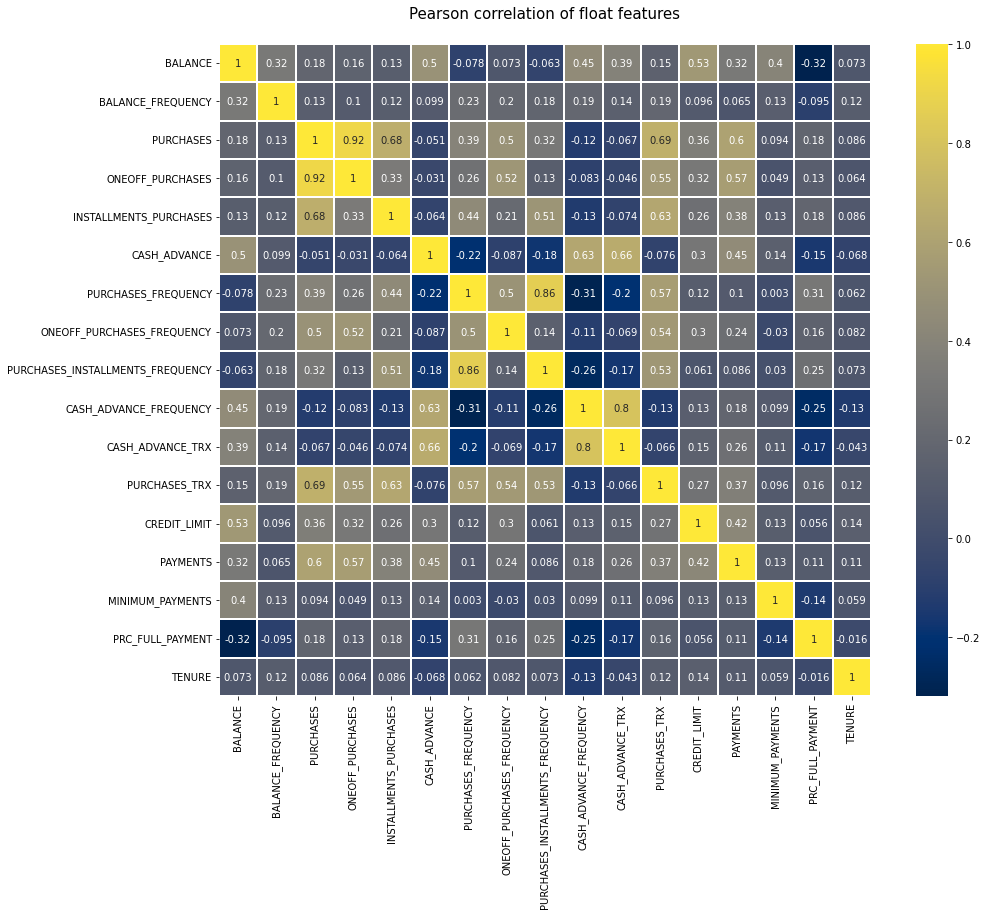

In [30]:
colormap = 'cividis'
plt.figure(figsize=(16,12))
plt.title('Pearson correlation', y=1.03, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

Analysis:

Based on the correlation matrix we can see some features with a fairly good correlation:
- ONEOFF_PURCHASES x PURCHASES = 0.92
- CASH_ADVANCE_TRX x CASH_ADVANCE_FREQUENCY = 0.8
- INSTALLMENTS_PURCHASES x PURCHASES = 0.68

Many other variables correlate between 0.5 and 0.7, which not very hight, but demonstrate a reasonable level of correlation.

#### Ouliers

#### Histograms and Skewness

#### Correlation

To do:
    - Deal with null values
    - Check skewness
    - Outliers
    - EDA
    